In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import torch
import torch.nn as nn

from numpy.linalg import inv

In [2]:
!curl "https://drive.usercontent.google.com/download?id={1iC4lTWN-w5eSVbbC16WDa002AoFg4kQa}&confirm=xxx" -o "Ferguson_fire_obs.npy"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2560k  100 2560k    0     0   625k      0  0:00:04  0:00:04 --:--:--  625k


## Load Images

In [3]:
task1_images = np.load("generated_data/task1_generated_images.npy")
task2_images = np.load("generated_data/task2_generated_images.npy")

satellite_images = np.load("Ferguson_fire_obs.npy")


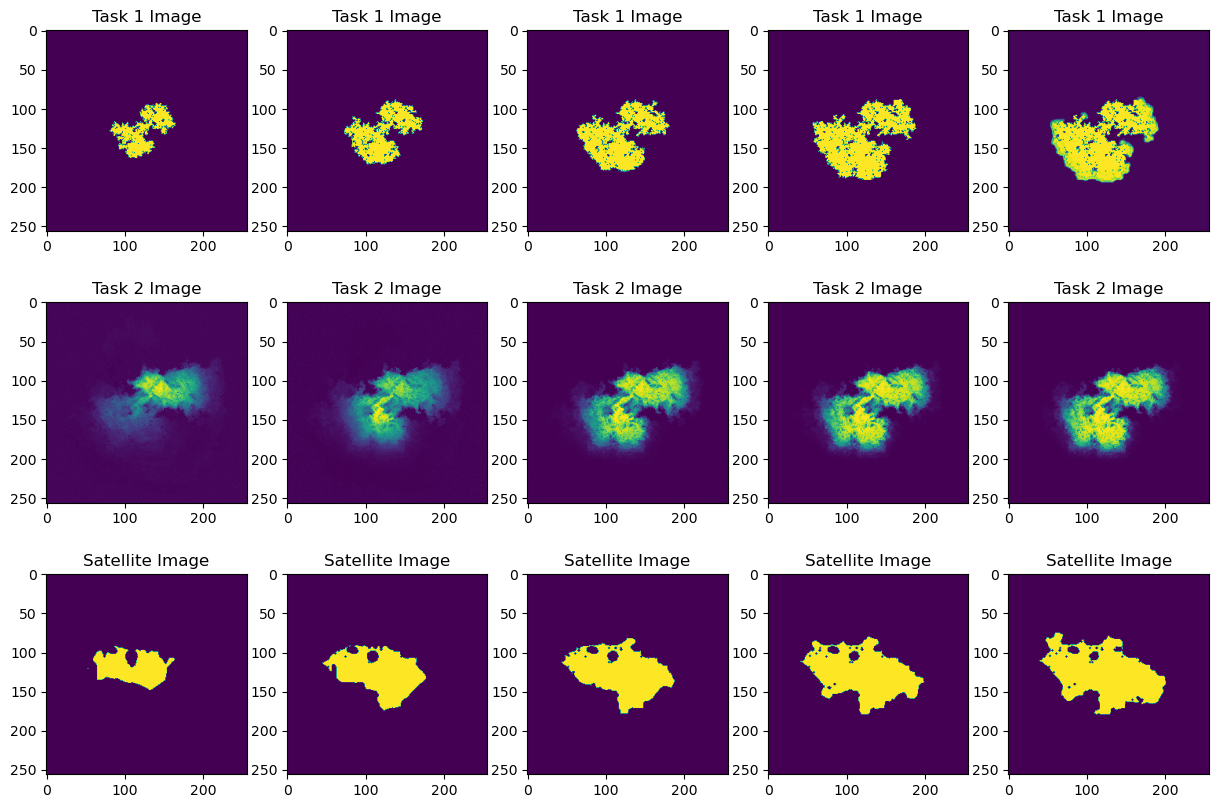

In [4]:
# plot the task 1, task 2 and satellite images, all have 5 images
fig, axs = plt.subplots(3, 5, figsize=(15, 10))
for i in range(5):
    axs[0, i].imshow(task1_images[i])
    axs[0, i].set_title("Task 1 Image")
    axs[1, i].imshow(task2_images[i])
    axs[1, i].set_title("Task 2 Image")
    axs[2, i].imshow(satellite_images[i])
    axs[2, i].set_title("Satellite Image")


## Compression Model (CAE)
### Model Structure

In [5]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 5, stride=2, padding=2),    # (1, 256, 256) -> (8, 128, 128)    
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),                         # (8, 128, 128) -> (8, 64, 64)
            nn.Conv2d(8, 16, 5, stride=2, padding=2),   # (8, 64, 64) -> (16, 32, 32)
            nn.LeakyReLU(),
            nn.Conv2d(16, 1, 3, stride=1, padding=1),   # (16, 32, 32) -> (1, 32, 32)
            nn.LeakyReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 16, 3, stride=1, padding=1),  # (1, 32, 32) -> (16, 32, 32)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=2, padding=2, output_padding=1),  # (16, 32, 32) -> (8, 64, 64)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 8, 5, stride=2, padding=2, output_padding=1),  # (8, 64, 64) -> (8, 128, 128)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 1, 5, stride=2, padding=2, output_padding=1),  # (8, 128, 128) -> (1, 256, 256)
            nn.Sigmoid()  # Using Sigmoid to output values in the range [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### Model training

In [ ]:
cae = ConvAutoencoder().to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(cae.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
liveloss = PlotLosses() 

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    cae.train()
    train_loss = 0
    for batch_X in train_loader:
        optimizer.zero_grad()
        batch_X = batch_X[0].to(device)
        batch_X = batch_X.view(-1, 1, 256, 256)
        outputs = cae(batch_X)
        loss = criterion(outputs, batch_X)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loop
    cae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X in validation_loader:
            batch_X = batch_X[0].to(device)
            batch_X = batch_X.view(-1, 1, 256, 256)
            outputs = cae(batch_X)
            loss = criterion(outputs, batch_X)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(validation_loader)
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': val_loss
    })
    liveloss.draw()

### Save model

In [50]:
# # save model 
torch.save(cae, 'Model/conv_autoencoder.pth')
#save model state
torch.save(cae.state_dict(), 'Model/conv_autoencoder_state_dict.pth')

### Load model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
cae = ConvAutoencoder().to(device)

In [10]:
# load model 
# cae = torch.load('Model/conv_autoencoder.pth', map_location=torch.device('cpu'))
# # load model state
# cae.load_state_dict(torch.load('Model/conv_autoencoder_state_dict.pth', map_location=torch.device('cpu')))
cae.load_state_dict(torch.load('conv_autoencoder_state_dict.pth', map_location=device))

<All keys matched successfully>

## Compress data

In [11]:
# use the model to compress the images
satellite_data_compr = cae.encoder(torch.tensor(satellite_images).float().reshape(5, 1, 256, 256)).detach().numpy().reshape(5, 32, 32)
task1_data_compr = cae.encoder(torch.tensor(task1_images).float().reshape(5, 1, 256, 256)).detach().numpy().reshape(5, 32, 32)
task2_data_compr = cae.encoder(torch.tensor(task2_images).float().reshape(5, 1, 256, 256)).detach().numpy().reshape(5, 32, 32)

# use the model to decompress the images
satellite_data_decompr = cae.decoder(torch.tensor(satellite_data_compr).float().reshape(5, 1, 32, 32)).detach().numpy().reshape(5, 256, 256)
# task1_data_decompr = cae.decoder(torch.tensor(generated_data_compr).float().reshape(5, 1, 32, 32)).detach().numpy().reshape(5, 256, 256)
# task2_data_decompr = cae.decoder(torch.tensor(generated_data_compr).float().reshape(5, 1, 32, 32)).detach().numpy().reshape(5, 256, 256)
task1_data_decompr = cae.decoder(torch.tensor(task1_data_compr).float().reshape(5, 1, 32, 32)).detach().numpy().reshape(5, 256, 256)
task2_data_decompr = cae.decoder(torch.tensor(task2_data_compr).float().reshape(5, 1, 32, 32)).detach().numpy().reshape(5, 256, 256)


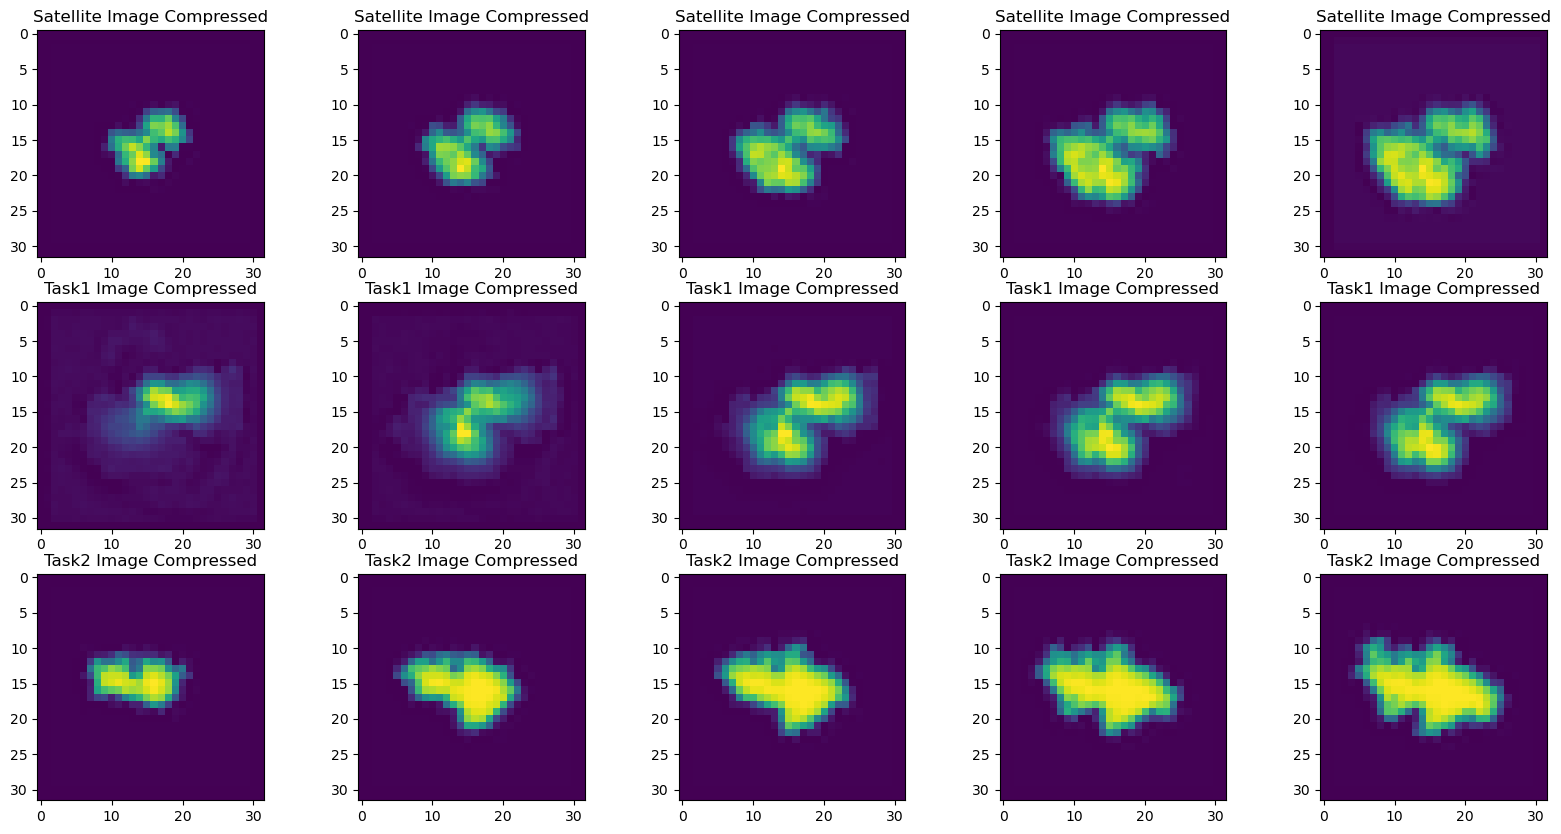

In [12]:
# plot the compressed images
fig, axs = plt.subplots(3, 5, figsize=(20, 10))
for i in range(5):
    axs[0, i].imshow(task1_data_compr[i])
    axs[0, i].set_title('Satellite Image Compressed')
    axs[1, i].imshow(task2_data_compr[i])
    axs[1, i].set_title('Task1 Image Compressed')
    axs[2, i].imshow(satellite_data_compr[i])
    axs[2, i].set_title('Task2 Image Compressed')
    

## Define functions for KF

In [13]:
# covariance_matrix
def covariance_matrix(X):
    means = np.mean(X, axis=0, keepdims=True)
    dev_matrix = X - means
    res = np.dot(dev_matrix.T, dev_matrix) / (X.shape[0] - 1)
    return res

# KalmanGain
def KalmanGain(B, H, R):
    tempInv = inv(R + np.dot(H, np.dot(B, H.T)))
    res = np.dot(B, np.dot(H.T, tempInv))
    return res

def update_prediction(x, K, H, y):
    res = x + np.dot(K, (y - np.dot(H, x)))
    return res

def mse(y_obs, y_pred):
    return np.square(np.subtract(y_obs, y_pred)).mean()

def grid_search(observation_data, model_data, R_factors, B_factors):
    num_timesteps, height, width = model_data.shape
    num_channels = height * width
    model_data_flat = model_data.reshape(num_timesteps, num_channels)
    observation_data_flat = observation_data.reshape(num_timesteps, num_channels)

    reshaped_data = model_data.reshape(num_timesteps, num_channels)
    
    initial_R = covariance_matrix(observation_data_flat)
    initial_B = np.diag(np.diag(covariance_matrix(model_data_flat)))

    best_R = None
    best_B = None
    best_mse = float('inf')
    
    for r_factor in R_factors:
        for b_factor in B_factors:
            R = initial_R * r_factor
            B = initial_B * b_factor
            
            # Compute Kalman gain
            H = np.eye(num_channels)  # Observation operator
            K = KalmanGain(B, H, R)
            
            # Update model data using the Kalman gain
            updated_model_data = []
            for i in range(num_timesteps):
                x_flat = model_data_flat[i]
                y_flat = observation_data_flat[i]
                updated_flat = update_prediction(x_flat, K, H, y_flat)
                updated_model_data.append(updated_flat.reshape(height, width))
            
            updated_model_data = np.array(updated_model_data)
            
            # Calculate MSE
            current_mse = mse(observation_data, updated_model_data)

            
            if current_mse < best_mse:
                best_mse = current_mse
                best_R = R
                best_B = B
    
    return best_R, best_B, best_mse


In [14]:
# Define grid search factors
R_factors = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
B_factors = [1, 10, 100, 1000, 10000, 100000]

R_task1, B_task1, best_mse = grid_search(satellite_data_compr, task1_data_compr, R_factors, B_factors)
R_task2, B_task2, best_mse = grid_search(satellite_data_compr, task2_data_compr, R_factors, B_factors)

# Setting the Kalman gain parameters
latent_space = np.square(satellite_data_compr.shape[1])

nNodes = latent_space
I = np.identity(nNodes)
H = I

K_task1 = KalmanGain(B_task1, H, R_task1)
K_task2 = KalmanGain(B_task2, H, R_task2)


In [15]:
import numpy as np
import torch

def update_data(task_data_compr, satellite_data_compr, cae, K, H, task_images, satellite_images, update_prediction):
    
    updated_task_data_compr = []

    task_name = "Task 1" if task_data_compr is task1_data_compr else "Task 2"

    for i in range(5):
        y = satellite_data_compr.reshape(5, -1)[i]
        x = task_data_compr.reshape(5, -1)[i]
        x = update_prediction(x, K, H, y)
        updated_task_data_compr.append(x)

    updated_task_data_compr = np.array(updated_task_data_compr)

    mse_before_DA = mse(satellite_data_compr, task_data_compr)
    mse_after_DA = mse(satellite_data_compr.reshape(5, -1), updated_task_data_compr)

    updated_task_data_recon = cae.decoder(torch.Tensor(updated_task_data_compr).reshape(5, 1, 32, 32)).detach().numpy().reshape(5, 256, 256)
    updated_task_data_recon = updated_task_data_recon.reshape(5, 256, 256)
    task_data_recon = task_images.reshape(5, 256, 256)

    physical_mse_before_da = mse(satellite_images, task_images)
    physical_mse_after_da = mse(satellite_images, updated_task_data_recon)

    print(task_name)
    print(f'MSE before DA in latent space: {mse_before_DA}')    
    print(f'MSE after DA in latent space: {mse_after_DA}')

    print(f'MSE before DA in physical space: {physical_mse_before_da}')
    print(f'MSE after DA in physical space: {physical_mse_after_da}')

    return updated_task_data_recon

In [16]:
updated_task1_data_recon = update_data(task1_data_compr, satellite_data_compr, cae, K_task1, H, task1_images, satellite_images, update_prediction)

Task 1
MSE before DA in latent space: 8.011186599731445
MSE after DA in latent space: 7.328342028383845e-11
MSE before DA in physical space: 0.0736069684661284
MSE after DA in physical space: 0.003956699384961284


In [17]:
updated_task2_data_recon = update_data(task2_data_compr, satellite_data_compr, cae, K_task2, H, task2_images, satellite_images, update_prediction)

Task 2
MSE before DA in latent space: 9.255593299865723
MSE after DA in latent space: 1.1293324210846848e-05
MSE before DA in physical space: 0.06613081121536987
MSE after DA in physical space: 0.003958540017822974


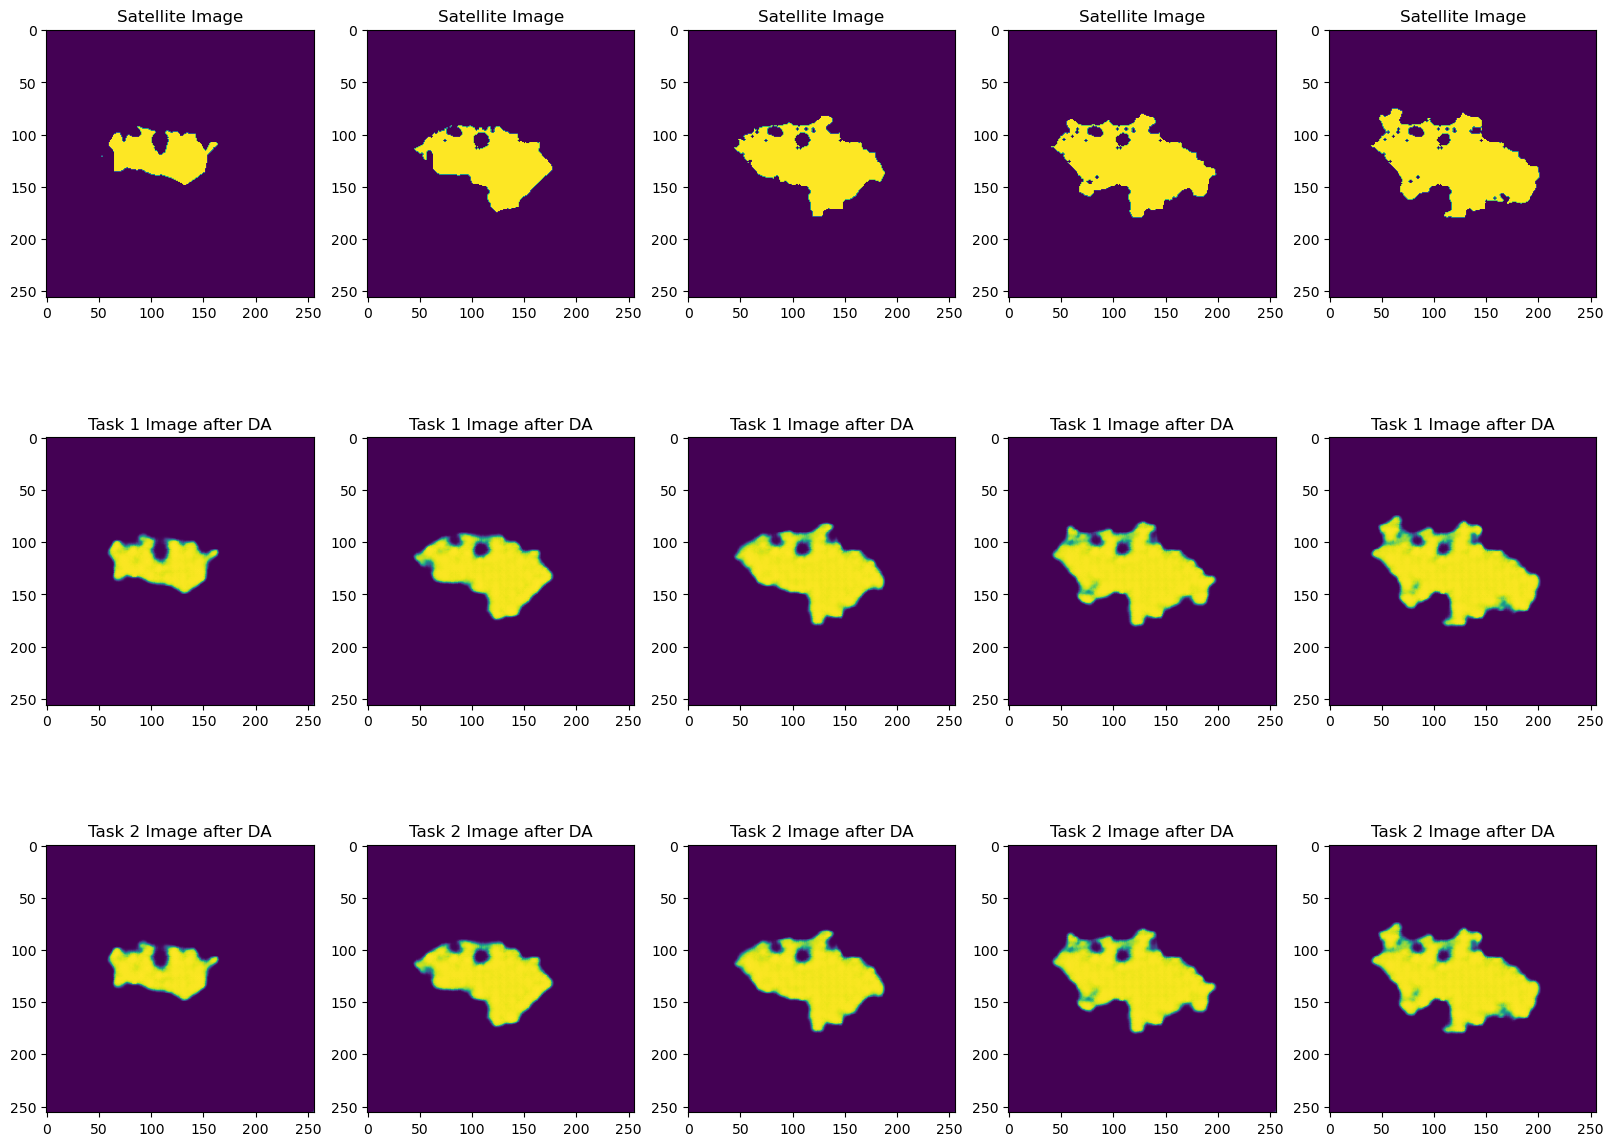

In [18]:
fig, ax = plt.subplots(3, 5, figsize=(20, 15))
for i in range(5):
    ax[0, i].imshow(satellite_images[i])
    ax[0, i].set_title('Satellite Image')
    ax[1, i].imshow(updated_task1_data_recon[i])
    ax[1, i].set_title('Task 1 Image after DA')
    ax[2, i].imshow(updated_task2_data_recon[i])
    ax[2, i].set_title('Task 2 Image after DA')